# A look at unique values in iDigBio using Apache Spark



In [4]:
%matplotlib inline 
from ggplot import *
import pandas as pd
from os import listdir

def get_counts(fn):
    return pd.read_csv(fn, header=None, names=["value", "count"])


def load_output_dir(dn, fields=None):
    retval = {}
    if fields is None:
        fields = []
        files = listdir(dn)
        for l in files:
            fields.append(l[len("unique_"):-1 * len(".csv")])

    for d in fields:
        
        l = "{0}/unique_{1}.csv".format(dn, d)
        #print "Loading {0}, fields is {1}".format(l, fields)
        retval[d] = get_counts(l)
        
    return retval


def plot_bar(df, y, title, xlabel, ylabel, log=False):
    p = ggplot(aes(x="x", y=y), data=df) \
        + geom_bar(stat='identity') \
        + theme(axis_text_x = element_text(angle = 90, hjust = 0.5)) \
        + scale_x_discrete(limits=(0 - 0.5, df.shape[0] + 0.5), 
                           breaks=range(0, df.shape[0]), 
                           labels=df.index) \
        + ggtitle(title) \
        + xlab(xlabel) \
        + ylab(ylabel)
        
    if log:
        p = p + scale_y_log10()
        
    return p


def plot_hist(df, x, title, xlabel, ylabel):
    # Figure size: https://github.com/yhat/ggplot/issues/95
    p = ggplot(aes(x=x), data=df) \
    + geom_histogram() \
    + scale_x_continuous(limits=(0-0.01, max(df[x].max()+0.01, .11))) \
    + ggtitle(title) \
    + xlab(xlabel) \
    + ylab(ylabel) \
    + theme_matplotlib(rc={"figure.figsize": "11, 4", "figure.max_open_warning": False}, 
                       matplotlib_defaults=False)
    return p


def plot_line(df, df_raw, x, y, title, xlabel, ylabel, log=False):
    p = ggplot(aes(x=x, y=y), data=df) \
        + geom_line(size=1, color="green") \
        + geom_line(aes(x=x, y=y), data=df_raw, size=1) \
        + ggtitle(title) \
        + xlab(xlabel) \
        + ylab(ylabel)
    if log:
        p = p + scale_y_log10()
        
    return p


iDigBio currently has over 260 data fields. Most are described by the Darwin Core and Audobon Core standards, some are unique to a particular provider's data use, and a handfull are used internally by iDigBio. One interesting question that comes up often is "What are the unique values in a field?"

As it turns out, that is a computationally expensive question to answer for a data set with 45 million reccords. Considering the dwc:country field, your first though might be to write a SQL query like:

SELECT country, count(*) FROM all_idigbio GROUP BY country;

iDigBio's data flexability and performance comes from storing provided data as PostgreSQL JSON data types. In such a schema, there is no county column to be indexed and grouped by. In our testing, an analogous query on the JSON column just never returns. For a searchable store, we use Elastic Search so a query that might work there could look like:

Unfortunately, that too performs terribly as Elastic Search's indexes are tuned for returning the most common occurences and not exhaustive lists. (See our "top" API endpoints for an example.)

Another option might be to get a CSV copy of iDigBio (which is around 30 GB uncompressed) and write some code in Python or another language to iterate through lines and keep track of unique values. (estimate on lines/second from Alex)

So what to do?

If you have looked in to the big data analytics eccosystem, you might have come across Apache Hadoop. Traditionally, Hadoop has been hard: hard to install, hard to maintain, and hard to write code for. But the computation pattern that Hadoop impliments, refered to map-reduce, is a great pattern for doing computations over large datasets. Hadoop was often the best solution for working with large datasets.

In the last two years a newer implimentation of the map-reduce model has been open sourced: Apache Spark. Spark is much easier to use than Hadoop and in most cases performs faster. Details about Spark and about the map-reduce computation pattern are (here).

Three easy parts about how Spark works are:

1. It is happy to use text files for input
1. You don't need to write special code to make your analysis happen in parallel
1. The same code can be run on one local machine or a whole cluster of machines

This means we can get close to the convenince of the Python and CSV option above and also run it on either a local development machine or a whole compute cluster. All we need is a running install of Spark and a few lines of Python. (Spark also has libraries for Scala and R if you prefer those languages.)

We wrote a Python script to read in both the raw and as-served occurrence CSV files that are in the Darwin Core Archive of all iDigBio data that can be downloaded from our full record set exports directory. For each field, the script produces a CSV file with all of the unique values in that field and the number of reccords that had that value.

An abreviated excerpt from the script showing the core Spark operations is below.


    fn = "data/{0}/occurrence{1}.csv".format(recordset, raw)
    sc = SparkContext(appName="UniqueCSVline")
    
    # Create a Resilient Distributed Dataset (RDD) containing a Python dictionary
    # of values for each record from the CSV of all iDigBio data and cache the 
    # RDD to memory
    records = sc.textFile(fn)
    parsed = records.map(lambda x: csvline.parse(x.encode("utf8"), headers) )
    parsed.cache()

    # For each field we want the unique values of, apply the map-reduce strategy
    # to find all the unique values
    for field in fields:
        counts = parsed.map(lambda x: (x[field], 1))
        totals = counts.reduceByKey(add)

        # Collect all the results on one node and write them to a CSV file
        output = totals.collect()
        out_fn = "{0}/unique_{1}.csv".format(out_dir, p.sub("_", field))
        with open(out_fn, "wb") as f:
            csvwriter = unicodecsv.writer(f, "excel")
            for (word, count) in output:
                csvwriter.writerow([word, count])


In [5]:
# Subset of fields for developing graphs
limited_fields = None
#limited_fields = ["dwc_country", "dwc_recordNumber", "dwc_locality"]

# small recordset
recordset = "00d9fcc1-c8e2-4ef6-be64-9994ca6a32c3"

# all of iDigBio ~4 min & 24 GB to load
#recordset = "idigbio"

In [6]:
counts = load_output_dir("../out_{0}".format(recordset), limited_fields)
counts_raw = load_output_dir("../out_raw_{0}".format(recordset), limited_fields)

In [7]:
# Build dataframe contianing the number of unique values for every field

c = {}
for k, df in counts.iteritems():
#    # reduce to just testing data
#    if testing_fields and not k in testing_fields:
#        continue
    c[k] = df.shape[0]

#print c
cardinalities = pd.DataFrame(c.values(), index=c.keys(), columns=["card"])

# Reduce the dataframe to just those fields that are not completely unique and those
# fields that are sparesely populated.
max_card = cardinalities.max()["card"] * 0.95
#min_card = cardinalities[cardinalities["card"] > 0].min()["card"] * 100
#min_card = 100000
min_card = 100
#print max_card
#print min_card
cardinalities = cardinalities[cardinalities["card"] < max_card]
cardinalities = cardinalities[cardinalities["card"] > min_card]


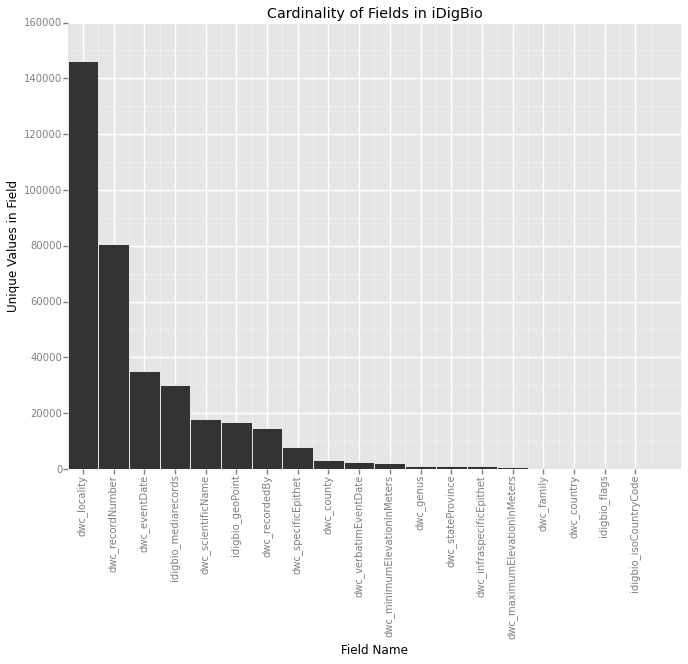

<ggplot: (8778327415705)>


In [11]:
# Sort for plotting and add an integer for the x-axis
cardinalities.sort(columns="card", inplace=True, ascending=False)
cardinalities["x"] = range(0, cardinalities.shape[0])


# small record set sizes: 187      389,196  146,346   80,476        3,180
#                         country  etag     locality  recordNumber  county

p = plot_bar(cardinalities, "card",
             "Cardinality of Fields in iDigBio",
             "Field Name",
             "Unique Values in Field")
print p


In [12]:
# As an alternative to the above, lets try a cumulative records graph. This shows the 
# cumulative number of records as each value is considered from most uncommon value to most 
# common.
def cumulate_df(df):
    # Remove blank/null value line, sort by increasing count
    df = df.sort("count")[ df["value"].notnull() ]
    
    # If the result is nothing left, return False
    if not df.shape[0] > 0:
        return False
    
    # Calculate cumulative count and percentage of records
    df["cum_count"] = df["count"].cumsum()
    df["cum_perc_pop"] = df["cum_count"] / df["count"].sum() * 100
    
    # add increasing integer x representing number of values for plotting
    df["x"] = range(0, df.shape[0])
    df["x_perc"] = df["x"] / df.shape[0] * 100
    
    return df

# Cumulate all the raw and corrected dataframes into dfs for graphing
dfs = {}
dfs_raw = {}
for f in counts.keys():
    df = cumulate_df(counts[f])
    if df is not False:
        dfs[f] = df
        
for f in counts_raw.keys():
    df = cumulate_df(counts_raw[f])
    if df is not False:
        dfs_raw[f] = df


figs = {}
for f in dfs.keys():
    
    if not isinstance(dfs_raw.get(f), pd.DataFrame):
        #print "No raw data for {0}".format(f)
        continue

    #print "Plotting {0}".format(f)
    figs[f] = plot_line(dfs[f], dfs_raw[f], "x", "cum_count",
                         "Cumulation of record counts by value for {}".format(f),
                         "Values, ascending frequency",
                         "Cumulative number of records")
    
#figs

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


(Observations from existing graph)

In addition to the cardinality, we can also look at the frequency which each value occurs within a field. And for extra fun, we can look at the frequency distributions of values both before and after data goes through iDigBio's data normalization efforts.

Below are graphs showing the cumulation of records over each unique value for a given field. The unique values along the x-axis are sorted from least common to most common to convey how the frequency of values changes.

Note that the actual values are not shown on the x-axis, there isn't room. The numbers on the x-axis are an increasing integer but you can tell how many unique values there are in a field from it. Also note that blank values are not considered on the y-axis.

Here's the graph of dwc:country:

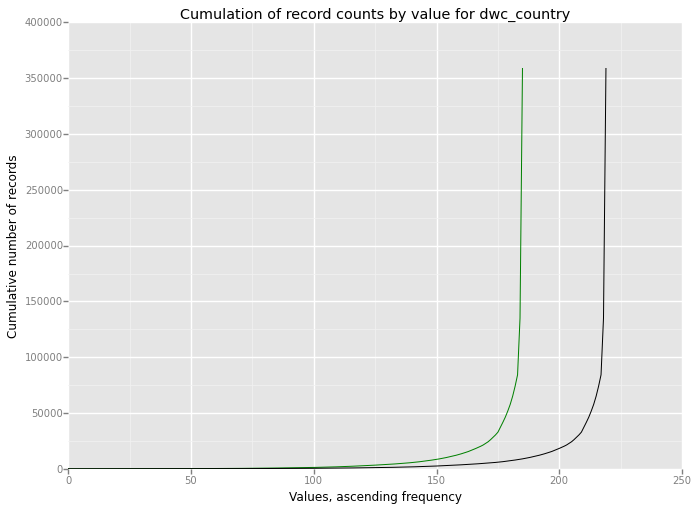

<ggplot: (8778222361801)>

In [13]:
figs["dwc_country"]

This seems intuitive. There are a few records from about 175 countries, most of the records are from about 10 countries, and there are about 185 countries with specimens in iDigBio. You can see a slight knee where there line becomes vertical at the most frequent value: "US". When the field is standardized to ISO country codes, the number of unique values drops as multiple representations of the same data dissapear. 

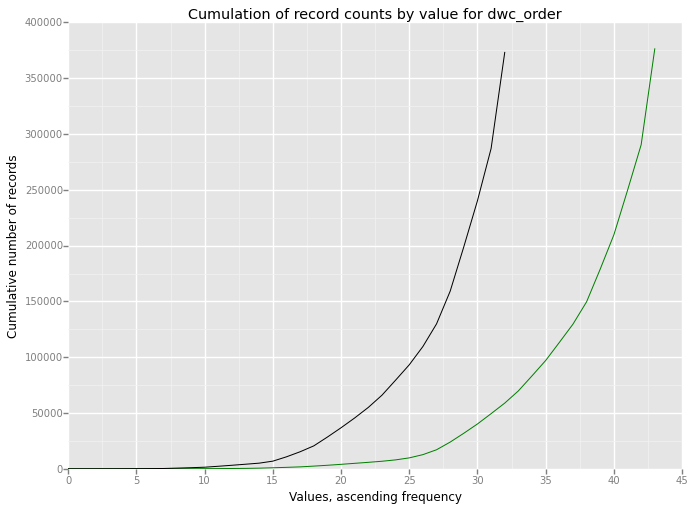

<ggplot: (8778222341521)>

In [16]:
figs["dwc_order"]

With the dwc:order field, things are a little different. Much of the data in iDigBio does not have higher taxonomy filled in so the raw data has fewer unique orders. When we take the provided names including family and fill in the higher ranks based on GBIF's taxonomy, we actually add unique values to the field.

In [17]:
print figs.keys()

['dwc_minimumElevationInMeters', 'dwc_collectionID', 'dwc_recordNumber', 'dwc_catalogNumber', 'dwc_verbatimEventDate', 'dwc_kingdom', 'dwc_typeStatus', 'dwc_scientificName', 'dwc_occurrenceID', 'dwc_class', 'dwc_basisOfRecord', 'dwc_specificEpithet', 'dwc_family', 'dwc_order', 'dwc_institutionCode', 'dwc_infraspecificEpithet', 'dwc_phylum', 'dwc_country', 'dwc_collectionCode', 'dwc_genus', 'dwc_locality', 'dwc_county', 'dwc_eventDate', 'dwc_recordedBy', 'dwc_maximumElevationInMeters', 'dwc_municipality', 'dwc_stateProvince']


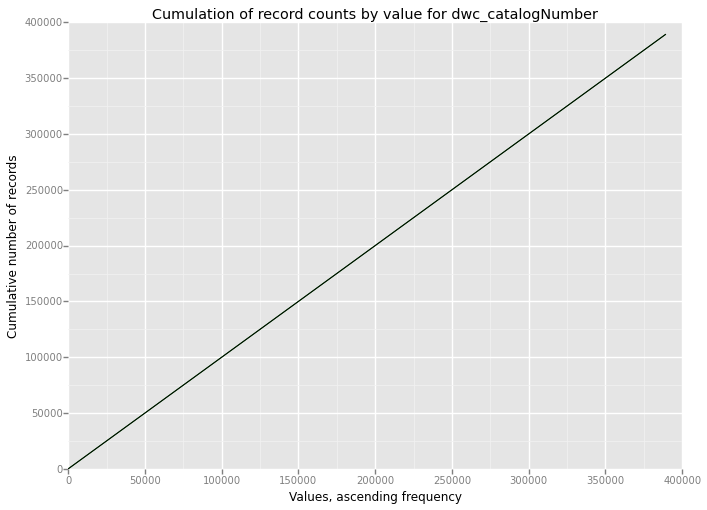

<ggplot: (8778222332457)>

In [19]:
figs["dwc_catalogNumber"]

Here is the dwc:catalog number field. If catalog number was globally unique this would be a line with a slope of 1. Of course, they're not but the lower section of the line does show that there are a lot of unique catalog numbers out there. The upper curve indicates 

We don't clean this field so there's no change between raw and indexed.

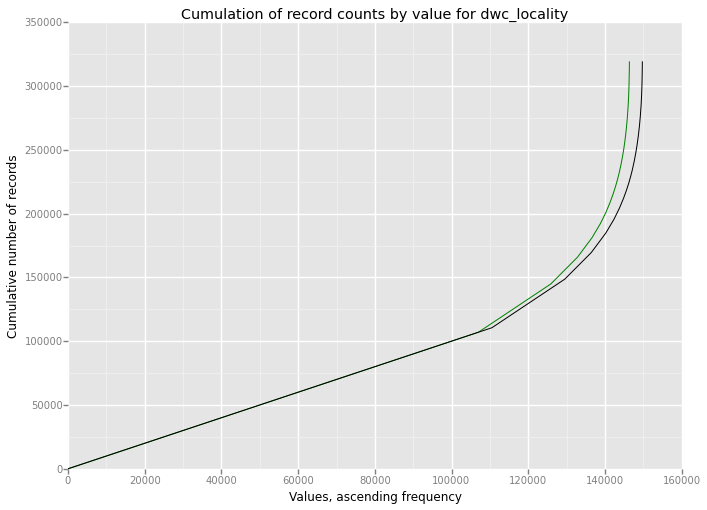

<ggplot: (8778222332061)>

In [20]:
figs["dwc_locality"]

Verbatim locality shows some similar trends with the lower part of the curve being several line segments clearly showing values that appear exactly once, twice, and three times.

What is interesting about this graph is that we don't clean locality strings. All we do is lowercase them in the index. The clean line shows fewer unique values simply because of the number of locality strings that differ by case only. (This is why we lower case data.)

This blog post was written from an iPython Notebook. You can [view the notebook through Github](https://github.com/iDigBio/idb-spark/blob/master/notebook/Cardinality_of_iDigBio_Data.ipynb), clone or fork the [github repository](https://github.com/iDigBio/idb-spark/) containing the notebook and Spark code, or look at the code in-line by clicking the button below:

In [2]:
# Hiding/Showing input cells
# http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')